In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import xgboost as xgb
print("xgb.__version__:", xgb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

xgb.__version__: 2.1.1


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# input parameters
fs_type = 'fsv24'
train_type = "small"

In [4]:
# Parameters
fs_type = "uni85"


In [5]:
# Load the feature selection results
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 264
Categorical features: 8
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 336
Categorical Columns: 8


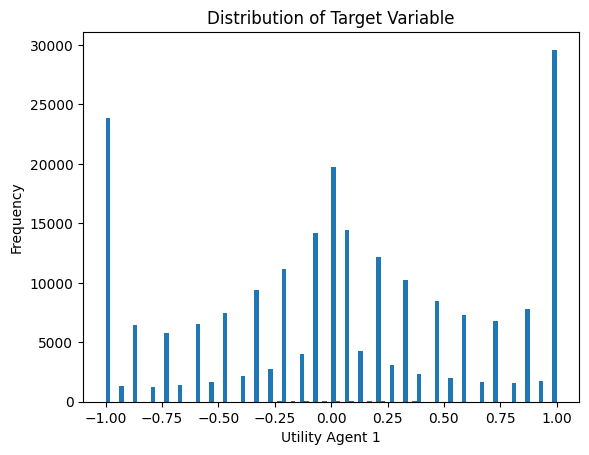

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [9]:
if train_type == "small":
    LEARNING_RATE = 0.03
    NUM_BOOST_ROUND = 2500
elif train_type == "medium":
    LEARNING_RATE = 0.01
    NUM_BOOST_ROUND = 5000
elif train_type == "large":
    LEARNING_RATE = 0.005
    NUM_BOOST_ROUND = 10_000
elif train_type == "xlarge":
    LEARNING_RATE = 0.001
    NUM_BOOST_ROUND = 20_000


print(LEARNING_RATE, NUM_BOOST_ROUND)

0.03 2500


In [10]:
def train_models(
        df_train,
        target,
        numerical_cols,
        categorical_cols,
        split_list=None
    ):
    # Define the parameters
    params = {
        'objective': "reg:squarederror",
        'eval_metric': 'rmse',
        'max_depth': 8,
        'max_bin': 128,
        'learning_rate': LEARNING_RATE,
        'alpha': 0.1,
        'colsample_bytree': 0.5,
        'subsample': 0.8,
        'min_child_weight': 10,
        'seed': 2112,
        'verbosity': 0,
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]

        feature_types = [
            "c" if col in categorical_cols else "q" 
            for col in numerical_cols + categorical_cols
        ]
        
        # Convert to DMatrix format
        train_data = xgb.DMatrix(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )
        val_data = xgb.DMatrix(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )

        # Train the model
        model = xgb.train(
            params,
            train_data,
            num_boost_round=NUM_BOOST_ROUND,
            evals=[(val_data, 'val')],
            verbose_eval=100,
        )
        
        # Get feature importance
        importance_dict = model.get_score(importance_type='gain')
        feat_importance = pd.DataFrame(
            {'feature': list(importance_dict.keys()),
             f'importance_f{fold}': list(importance_dict.values())}
        )
        feat_importance_dfs.append(feat_importance)
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(val_data)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold

        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv1.parquet', index=False)

Fold 1


[0]	val-rmse:0.55524


[100]	val-rmse:0.46862


[200]	val-rmse:0.44955


[300]	val-rmse:0.44189


[400]	val-rmse:0.43614


[500]	val-rmse:0.43296


[600]	val-rmse:0.43136


[700]	val-rmse:0.43016


[800]	val-rmse:0.42919


[900]	val-rmse:0.42857


[1000]	val-rmse:0.42817


[1100]	val-rmse:0.42781


[1200]	val-rmse:0.42763


[1300]	val-rmse:0.42766


[1400]	val-rmse:0.42756


[1500]	val-rmse:0.42764


[1600]	val-rmse:0.42761


[1700]	val-rmse:0.42765


[1800]	val-rmse:0.42761


[1900]	val-rmse:0.42757


[2000]	val-rmse:0.42752


[2100]	val-rmse:0.42755


[2200]	val-rmse:0.42754


[2300]	val-rmse:0.42760


[2400]	val-rmse:0.42772


[2499]	val-rmse:0.42778


Fold 1 - RMSE: 0.42743694484354167
Fold 2


[0]	val-rmse:0.58933


[100]	val-rmse:0.48275


[200]	val-rmse:0.46751


[300]	val-rmse:0.46123


[400]	val-rmse:0.45758


[500]	val-rmse:0.45508


[600]	val-rmse:0.45333


[700]	val-rmse:0.45195


[800]	val-rmse:0.45097


[900]	val-rmse:0.45016


[1000]	val-rmse:0.44967


[1100]	val-rmse:0.44910


[1200]	val-rmse:0.44880


[1300]	val-rmse:0.44838


[1400]	val-rmse:0.44824


[1500]	val-rmse:0.44790


[1600]	val-rmse:0.44768


[1700]	val-rmse:0.44758


[1800]	val-rmse:0.44755


[1900]	val-rmse:0.44748


[2000]	val-rmse:0.44750


[2100]	val-rmse:0.44742


[2200]	val-rmse:0.44752


[2300]	val-rmse:0.44749


[2400]	val-rmse:0.44741


[2499]	val-rmse:0.44740


Fold 2 - RMSE: 0.44695660697190565
Fold 3


[0]	val-rmse:0.60728


[100]	val-rmse:0.48455


[200]	val-rmse:0.46390


[300]	val-rmse:0.45635


[400]	val-rmse:0.45221


[500]	val-rmse:0.44958


[600]	val-rmse:0.44777


[700]	val-rmse:0.44654


[800]	val-rmse:0.44551


[900]	val-rmse:0.44486


[1000]	val-rmse:0.44468


[1100]	val-rmse:0.44427


[1200]	val-rmse:0.44391


[1300]	val-rmse:0.44359


[1400]	val-rmse:0.44319


[1500]	val-rmse:0.44296


[1600]	val-rmse:0.44281


[1700]	val-rmse:0.44274


[1800]	val-rmse:0.44262


[1900]	val-rmse:0.44251


[2000]	val-rmse:0.44235


[2100]	val-rmse:0.44224


[2200]	val-rmse:0.44218


[2300]	val-rmse:0.44226


[2400]	val-rmse:0.44227


[2499]	val-rmse:0.44229


Fold 3 - RMSE: 0.4418147757119552
Fold 4


[0]	val-rmse:0.59756


[100]	val-rmse:0.48497


[200]	val-rmse:0.46488


[300]	val-rmse:0.45711


[400]	val-rmse:0.45242


[500]	val-rmse:0.44924


[600]	val-rmse:0.44747


[700]	val-rmse:0.44593


[800]	val-rmse:0.44502


[900]	val-rmse:0.44452


[1000]	val-rmse:0.44391


[1100]	val-rmse:0.44370


[1200]	val-rmse:0.44354


[1300]	val-rmse:0.44308


[1400]	val-rmse:0.44284


[1500]	val-rmse:0.44276


[1600]	val-rmse:0.44266


[1700]	val-rmse:0.44252


[1800]	val-rmse:0.44232


[1900]	val-rmse:0.44206


[2000]	val-rmse:0.44204


[2100]	val-rmse:0.44191


[2200]	val-rmse:0.44191


[2300]	val-rmse:0.44198


[2400]	val-rmse:0.44192


[2499]	val-rmse:0.44190


Fold 4 - RMSE: 0.4414480811684964
Fold 5


[0]	val-rmse:0.54858


[100]	val-rmse:0.45616


[200]	val-rmse:0.43441


[300]	val-rmse:0.42405


[400]	val-rmse:0.41712


[500]	val-rmse:0.41366


[600]	val-rmse:0.41139


[700]	val-rmse:0.40997


[800]	val-rmse:0.40894


[900]	val-rmse:0.40816


[1000]	val-rmse:0.40775


[1100]	val-rmse:0.40743


[1200]	val-rmse:0.40697


[1300]	val-rmse:0.40668


[1400]	val-rmse:0.40648


[1500]	val-rmse:0.40647


[1600]	val-rmse:0.40647


[1700]	val-rmse:0.40647


[1800]	val-rmse:0.40646


[1900]	val-rmse:0.40659


[2000]	val-rmse:0.40660


[2100]	val-rmse:0.40657


[2200]	val-rmse:0.40658


[2300]	val-rmse:0.40656


[2400]	val-rmse:0.40668


[2499]	val-rmse:0.40661


Fold 5 - RMSE: 0.40633036052174504
List of oof scores: [0.42743694484354167, 0.44695660697190565, 0.4418147757119552, 0.4414480811684964, 0.40633036052174504]
Average oof score: 0.43279735384352885


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv2.parquet', index=False)

Fold 1


[0]	val-rmse:0.53664


[100]	val-rmse:0.45086


[200]	val-rmse:0.43344


[300]	val-rmse:0.42717


[400]	val-rmse:0.42264


[500]	val-rmse:0.41942


[600]	val-rmse:0.41760


[700]	val-rmse:0.41649


[800]	val-rmse:0.41551


[900]	val-rmse:0.41462


[1000]	val-rmse:0.41417


[1100]	val-rmse:0.41360


[1200]	val-rmse:0.41321


[1300]	val-rmse:0.41301


[1400]	val-rmse:0.41271


[1500]	val-rmse:0.41251


[1600]	val-rmse:0.41249


[1700]	val-rmse:0.41238


[1800]	val-rmse:0.41220


[1900]	val-rmse:0.41216


[2000]	val-rmse:0.41215


[2100]	val-rmse:0.41215


[2200]	val-rmse:0.41215


[2300]	val-rmse:0.41207


[2400]	val-rmse:0.41204


[2499]	val-rmse:0.41205


Fold 1 - RMSE: 0.41181229922148344
Fold 2


[0]	val-rmse:0.54837


[100]	val-rmse:0.43370


[200]	val-rmse:0.41628


[300]	val-rmse:0.41140


[400]	val-rmse:0.40816


[500]	val-rmse:0.40657


[600]	val-rmse:0.40517


[700]	val-rmse:0.40462


[800]	val-rmse:0.40421


[900]	val-rmse:0.40405


[1000]	val-rmse:0.40375


[1100]	val-rmse:0.40387


[1200]	val-rmse:0.40370


[1300]	val-rmse:0.40371


[1400]	val-rmse:0.40355


[1500]	val-rmse:0.40355


[1600]	val-rmse:0.40364


[1700]	val-rmse:0.40367


[1800]	val-rmse:0.40388


[1900]	val-rmse:0.40397


[2000]	val-rmse:0.40397


[2100]	val-rmse:0.40401


[2200]	val-rmse:0.40403


[2300]	val-rmse:0.40413


[2400]	val-rmse:0.40431


[2499]	val-rmse:0.40446


Fold 2 - RMSE: 0.4039065884368822
Fold 3


[0]	val-rmse:0.61425


[100]	val-rmse:0.49005


[200]	val-rmse:0.46555


[300]	val-rmse:0.45601


[400]	val-rmse:0.44960


[500]	val-rmse:0.44601


[600]	val-rmse:0.44391


[700]	val-rmse:0.44240


[800]	val-rmse:0.44129


[900]	val-rmse:0.44032


[1000]	val-rmse:0.43963


[1100]	val-rmse:0.43915


[1200]	val-rmse:0.43869


[1300]	val-rmse:0.43827


[1400]	val-rmse:0.43806


[1500]	val-rmse:0.43780


[1600]	val-rmse:0.43756


[1700]	val-rmse:0.43726


[1800]	val-rmse:0.43706


[1900]	val-rmse:0.43709


[2000]	val-rmse:0.43703


[2100]	val-rmse:0.43695


[2200]	val-rmse:0.43695


[2300]	val-rmse:0.43680


[2400]	val-rmse:0.43669


[2499]	val-rmse:0.43660


Fold 3 - RMSE: 0.4361332995912844
Fold 4


[0]	val-rmse:0.60698


[100]	val-rmse:0.49090


[200]	val-rmse:0.46543


[300]	val-rmse:0.45656


[400]	val-rmse:0.45171


[500]	val-rmse:0.44851


[600]	val-rmse:0.44688


[700]	val-rmse:0.44548


[800]	val-rmse:0.44459


[900]	val-rmse:0.44373


[1000]	val-rmse:0.44347


[1100]	val-rmse:0.44307


[1200]	val-rmse:0.44285


[1300]	val-rmse:0.44255


[1400]	val-rmse:0.44210


[1500]	val-rmse:0.44215


[1600]	val-rmse:0.44222


[1700]	val-rmse:0.44205


[1800]	val-rmse:0.44192


[1900]	val-rmse:0.44192


[2000]	val-rmse:0.44178


[2100]	val-rmse:0.44185


[2200]	val-rmse:0.44188


[2300]	val-rmse:0.44176


[2400]	val-rmse:0.44172


[2499]	val-rmse:0.44175


Fold 4 - RMSE: 0.44143939899323287
Fold 5


[0]	val-rmse:0.59340


[100]	val-rmse:0.48245


[200]	val-rmse:0.46031


[300]	val-rmse:0.45115


[400]	val-rmse:0.44535


[500]	val-rmse:0.44219


[600]	val-rmse:0.44022


[700]	val-rmse:0.43896


[800]	val-rmse:0.43826


[900]	val-rmse:0.43745


[1000]	val-rmse:0.43670


[1100]	val-rmse:0.43640


[1200]	val-rmse:0.43608


[1300]	val-rmse:0.43579


[1400]	val-rmse:0.43551


[1500]	val-rmse:0.43543


[1600]	val-rmse:0.43542


[1700]	val-rmse:0.43515


[1800]	val-rmse:0.43516


[1900]	val-rmse:0.43505


[2000]	val-rmse:0.43504


[2100]	val-rmse:0.43500


[2200]	val-rmse:0.43509


[2300]	val-rmse:0.43504


[2400]	val-rmse:0.43506


[2499]	val-rmse:0.43508


Fold 5 - RMSE: 0.4345577930747407
List of oof scores: [0.41181229922148344, 0.4039065884368822, 0.4361332995912844, 0.44143939899323287, 0.4345577930747407]
Average oof score: 0.4255698758635247


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv3.parquet', index=False)

Fold 1


[0]	val-rmse:0.57673


[100]	val-rmse:0.47961


[200]	val-rmse:0.45934


[300]	val-rmse:0.45121


[400]	val-rmse:0.44702


[500]	val-rmse:0.44423


[600]	val-rmse:0.44265


[700]	val-rmse:0.44161


[800]	val-rmse:0.44121


[900]	val-rmse:0.44062


[1000]	val-rmse:0.44022


[1100]	val-rmse:0.43988


[1200]	val-rmse:0.43946


[1300]	val-rmse:0.43918


[1400]	val-rmse:0.43898


[1500]	val-rmse:0.43898


[1600]	val-rmse:0.43881


[1700]	val-rmse:0.43869


[1800]	val-rmse:0.43867


[1900]	val-rmse:0.43871


[2000]	val-rmse:0.43864


[2100]	val-rmse:0.43857


[2200]	val-rmse:0.43858


[2300]	val-rmse:0.43863


[2400]	val-rmse:0.43878


[2499]	val-rmse:0.43882


Fold 1 - RMSE: 0.4382400440806102
Fold 2


[0]	val-rmse:0.57660


[100]	val-rmse:0.46875


[200]	val-rmse:0.44538


[300]	val-rmse:0.43591


[400]	val-rmse:0.42988


[500]	val-rmse:0.42622


[600]	val-rmse:0.42352


[700]	val-rmse:0.42176


[800]	val-rmse:0.42054


[900]	val-rmse:0.41943


[1000]	val-rmse:0.41863


[1100]	val-rmse:0.41816


[1200]	val-rmse:0.41765


[1300]	val-rmse:0.41739


[1400]	val-rmse:0.41713


[1500]	val-rmse:0.41692


[1600]	val-rmse:0.41680


[1700]	val-rmse:0.41659


[1800]	val-rmse:0.41650


[1900]	val-rmse:0.41634


[2000]	val-rmse:0.41631


[2100]	val-rmse:0.41625


[2200]	val-rmse:0.41635


[2300]	val-rmse:0.41616


[2400]	val-rmse:0.41603


[2499]	val-rmse:0.41605


Fold 2 - RMSE: 0.4157968324368809
Fold 3


[0]	val-rmse:0.57887


[100]	val-rmse:0.47097


[200]	val-rmse:0.45230


[300]	val-rmse:0.44411


[400]	val-rmse:0.43967


[500]	val-rmse:0.43716


[600]	val-rmse:0.43586


[700]	val-rmse:0.43509


[800]	val-rmse:0.43411


[900]	val-rmse:0.43341


[1000]	val-rmse:0.43306


[1100]	val-rmse:0.43283


[1200]	val-rmse:0.43257


[1300]	val-rmse:0.43222


[1400]	val-rmse:0.43175


[1500]	val-rmse:0.43165


[1600]	val-rmse:0.43143


[1700]	val-rmse:0.43146


[1800]	val-rmse:0.43129


[1900]	val-rmse:0.43126


[2000]	val-rmse:0.43135


[2100]	val-rmse:0.43142


[2200]	val-rmse:0.43147


[2300]	val-rmse:0.43145


[2400]	val-rmse:0.43142


[2499]	val-rmse:0.43145


Fold 3 - RMSE: 0.43116305762721857
Fold 4


[0]	val-rmse:0.57711


[100]	val-rmse:0.46000


[200]	val-rmse:0.44130


[300]	val-rmse:0.43379


[400]	val-rmse:0.42846


[500]	val-rmse:0.42540


[600]	val-rmse:0.42375


[700]	val-rmse:0.42265


[800]	val-rmse:0.42181


[900]	val-rmse:0.42110


[1000]	val-rmse:0.42058


[1100]	val-rmse:0.42015


[1200]	val-rmse:0.41978


[1300]	val-rmse:0.41952


[1400]	val-rmse:0.41920


[1500]	val-rmse:0.41916


[1600]	val-rmse:0.41910


[1700]	val-rmse:0.41906


[1800]	val-rmse:0.41891


[1900]	val-rmse:0.41888


[2000]	val-rmse:0.41878


[2100]	val-rmse:0.41878


[2200]	val-rmse:0.41867


[2300]	val-rmse:0.41858


[2400]	val-rmse:0.41857


[2499]	val-rmse:0.41861


Fold 4 - RMSE: 0.4182808960919118
Fold 5


[0]	val-rmse:0.58665


[100]	val-rmse:0.47603


[200]	val-rmse:0.45548


[300]	val-rmse:0.44631


[400]	val-rmse:0.44018


[500]	val-rmse:0.43636


[600]	val-rmse:0.43407


[700]	val-rmse:0.43249


[800]	val-rmse:0.43149


[900]	val-rmse:0.43063


[1000]	val-rmse:0.43020


[1100]	val-rmse:0.42976


[1200]	val-rmse:0.42924


[1300]	val-rmse:0.42885


[1400]	val-rmse:0.42858


[1500]	val-rmse:0.42825


[1600]	val-rmse:0.42814


[1700]	val-rmse:0.42800


[1800]	val-rmse:0.42786


[1900]	val-rmse:0.42773


[2000]	val-rmse:0.42762


[2100]	val-rmse:0.42750


[2200]	val-rmse:0.42747


[2300]	val-rmse:0.42730


[2400]	val-rmse:0.42735


[2499]	val-rmse:0.42742


Fold 5 - RMSE: 0.42709748479882464
List of oof scores: [0.4382400440806102, 0.4157968324368809, 0.43116305762721857, 0.4182808960919118, 0.42709748479882464]
Average oof score: 0.4261156630070892


In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4274
Score: 0.4470
Score: 0.4418
Score: 0.4414
Score: 0.4063
Average CV1 Score: 0.4328

CV2 OOF Scores:
Score: 0.4118
Score: 0.4039
Score: 0.4361
Score: 0.4414
Score: 0.4346
Average CV2 Score: 0.4256

CV3 OOF Scores:
Score: 0.4382
Score: 0.4158
Score: 0.4312
Score: 0.4183
Score: 0.4271
Average CV3 Score: 0.4261


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

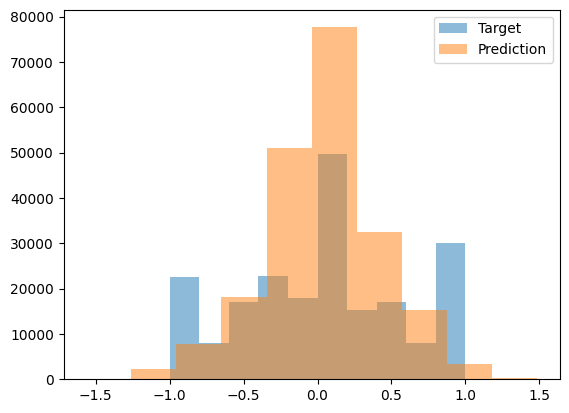

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Create feature types list for XGBoost
    feature_types = [
        "c" if col in categorical_cols else "q" 
        for col in numerical_cols + categorical_cols
    ]

    # Create XGBoost DMatrix for test data
    test_dmatrix = xgb.DMatrix(
        data=test_processed[numerical_cols + categorical_cols],
        feature_types=feature_types,
        enable_categorical=True
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_dmatrix)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [20]:
# Save all artifacts needed for prediction
xgboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'encoder': encoder,
    'scaler': scaler
}

with open(f'./xgboost_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(xgboost_predict, f)

***